Liczba braków w SOY (przed): 36
Liczba braków w SOY (po):    0


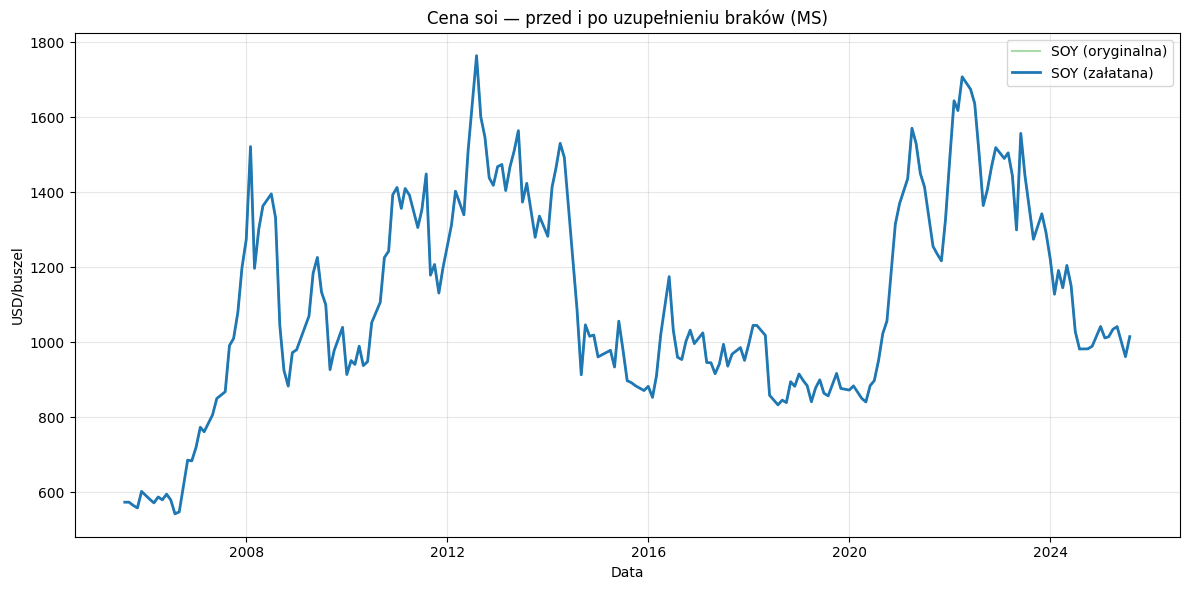

Zapisano serię po uzupełnieniu braków → data\soy_simple_monthly_filled.csv


In [9]:
# %% KROK 1 — wczytaj i ZAŁATAJ DZIURY w SOY (miesięcznie, MS)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- pliki ---
IN_CSV  = os.path.join("data", "soy_simple_monthly.csv")
OUT_CSV = os.path.join("data", "soy_simple_monthly_filled.csv")

# --- wczytaj ---
df = pd.read_csv(IN_CSV, parse_dates=["date"]).set_index("date").sort_index()

if "SOY" not in df.columns:
    raise ValueError("Brak kolumny 'SOY' w pliku wejściowym.")

# --- 1) upewnij się, że indeks to pełna siatka miesięczna (MS) ---
#     (tworzymy pełny grid od pierwszego do ostatniego miesiąca)
start = df.index.min().to_period("M").to_timestamp(how="start")
end   = df.index.max().to_period("M").to_timestamp(how="start")
grid  = pd.date_range(start=start, end=end, freq="MS")
df    = df.reindex(grid)  # wstaw NaN tam, gdzie były „dziury” w miesiącach

# --- 2) zalep dziury TYLKO w SOY ---
#     - najpierw interpolacja liniowa (po czasie)
#     - potem bfill/ffill na brzegach (gdy początek/koniec ma NaN)
soy_orig   = df["SOY"].copy()
soy_interp = soy_orig.interpolate(method="time")
soy_filled = soy_interp.bfill().ffill()

df["SOY"] = soy_filled

# (opcjonalnie) NIE tykamy pozostałych kolumn; jeśli chcesz je też łatać:
# for c in df.columns:
#     if c == "SOY": 
#         continue
#     df[c] = df[c].interpolate(method="time").bfill().ffill()

# --- 3) szybki podgląd różnic ---
print("Liczba braków w SOY (przed):", int(soy_orig.isna().sum()))
print("Liczba braków w SOY (po):   ", int(df['SOY'].isna().sum()))

# --- 4) wykres porównawczy ---
plt.figure(figsize=(12,6))
plt.plot(df.index, soy_orig,   label="SOY (oryginalna)", color="tab:green", alpha=0.4)
plt.plot(df.index, df["SOY"], label="SOY (załatana)",   color="tab:blue",  linewidth=2)
plt.title("Cena soi — przed i po uzupełnieniu braków (MS)")
plt.xlabel("Data"); plt.ylabel("USD/buszel")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# --- 5) zapisz wynik ---
df.to_csv(OUT_CSV, index_label="date")
print(f"Zapisano serię po uzupełnieniu braków → {OUT_CSV}")


In [16]:
df.to_csv(OUT_CSV, index_label="date")


=== FEATURES USED BY THE MODEL ===
- SOY lags: lag0, lag1, lag2, lag3, lag4, lag5, lag6
- Exogenous variables (each with lags 0..6):
    • WX_US
    • WX_BR
    • ONI
    • FX_USDBRL
    • FX_EURUSD
    • DXY
    • SOY_t+1
    • SOY_t+2
    • SOY_t+3



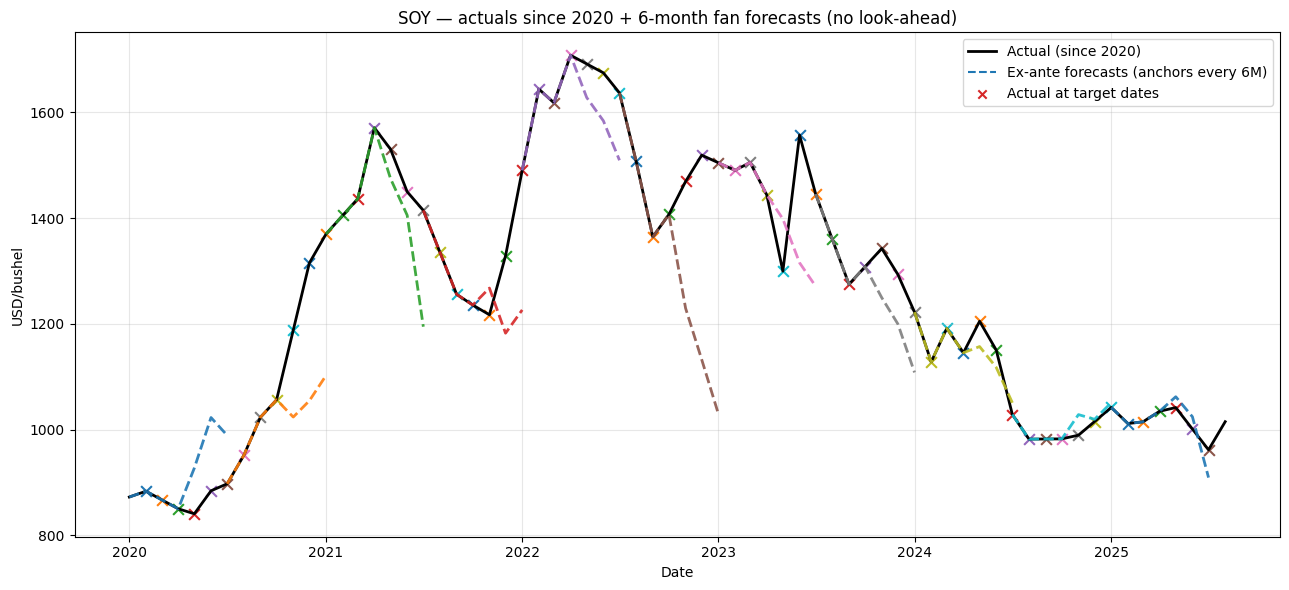

MAE on displayed ex-ante segments (since 2020):
  h=1: MAE = 0.000 USD/bushel
  h=2: MAE = 0.000 USD/bushel
  h=3: MAE = 0.000 USD/bushel
  h=4: MAE = 87.243 USD/bushel
  h=5: MAE = 132.998 USD/bushel
  h=6: MAE = 165.292 USD/bushel

Forecast-from-now anchor: 2025-08-01


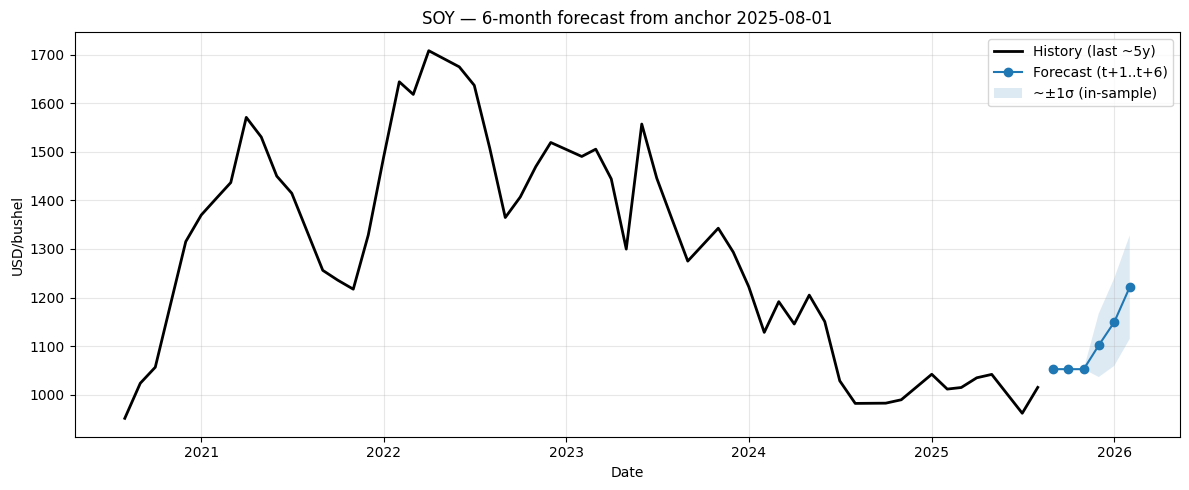


Forecasts from now (point, ±1σ if available):
  2025-09-01  (h=1):  1052.500 ± 0.000
  2025-10-01  (h=2):  1052.500 ± 0.000
  2025-11-01  (h=3):  1052.500 ± 0.000
  2025-12-01  (h=4):  1101.623 ± 65.356
  2026-01-01  (h=5):  1149.428 ± 90.191
  2026-02-01  (h=6):  1221.550 ± 106.564


In [2]:
# %% SOY — 6-miesięczne prognozy: wachlarze ex-ante od 2020 + prognoza "od teraz"
# -----------------------------------------------------------------------------
# Co model bierze pod uwagę?
# - Zmienna celu: miesięczna cena SOY.
# - Cechy (features):
#   * SOY_lag0..lag6  -> bieżąca cena w miesiącu kotwicy + 6 poprzednich miesięcy.
#   * Dla każdej kolumny egzogenicznej z pliku (dowolna nazwa != SOY):
#       X_lag0..lag6  -> wartość w miesiącu kotwicy + 6 poprzednich miesięcy.
# - Dla każdego horyzontu h=1..6 trenuje się osobny model liniowy.
# - Zero "look-ahead": dla anchor i h model uczy się wyłącznie na danych <= anchor-h.
# - Prognoza "od teraz": anchor = ostatni kompletny miesiąc w danych, predykcja na kolejne 6 mies.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# --------------------------- Parametry użytkownika ----------------------------
IN_FILLED = os.path.join("data", "soy_simple_monthly_filled.csv")
PLOT_START = pd.Timestamp("2020-01-01")   # historia do rysowania wachlarzy
HORIZONS = [1, 2, 3, 4, 5, 6]
SOY_LAGS = list(range(0, 7))              # 0..6
EXOG_LAGS = list(range(0, 7))             # 0..6
ANCHOR_STEP_MONTHS = 6                    # co ile miesięcy rysować wachlarz ex-ante

# ------------------------------ Wczytanie danych -----------------------------
df = pd.read_csv(IN_FILLED, parse_dates=["date"]).set_index("date").sort_index()
if "SOY" not in df.columns:
    raise ValueError("Column 'SOY' not found in soy_simple_monthly_filled.csv")

# -------------------------- Budowa cech (features) ---------------------------
# (1) Lags dla SOY
for L in SOY_LAGS:
    df[f"SOY_lag{L}"] = df["SOY"].shift(L)

# (2) Lags dla kolumn egzogenicznych (wszystko co nie jest już lagiem i nie jest SOY)
def _is_existing_lag_col(c: str) -> bool:
    return c == "SOY" or c.startswith("SOY_lag") or any(c.endswith(f"_lag{k}") for k in range(0, 13))

exog_raw = [c for c in df.columns if not _is_existing_lag_col(c)]
for c in exog_raw:
    for L in EXOG_LAGS:
        df[f"{c}_lag{L}"] = df[c].shift(L)

# (3) Targety t+h
for h in HORIZONS:
    df[f"SOY_t+{h}"] = df["SOY"].shift(-h)

# (4) Ostateczna lista cech
feature_cols = [c for c in df.columns if c.startswith("SOY_lag") or any(c.endswith(f"_lag{k}") for k in EXOG_LAGS)]

# ------------------------ Preprocessing + model bazowy -----------------------
pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), feature_cols)
])

def make_model():
    return Pipeline([("pre", pre), ("lin", LinearRegression())])

# --------------------------- Drukuj, co używa model --------------------------
print("\n=== FEATURES USED BY THE MODEL ===")
print(f"- SOY lags: {', '.join([f'lag{L}' for L in SOY_LAGS])}")
if exog_raw:
    print("- Exogenous variables (each with lags 0..6):")
    for c in exog_raw:
        print(f"    • {c}")
else:
    print("- No exogenous variables found (only SOY lags will be used).")
print("==================================\n")

# ----------------------- Wachlarze ex-ante (od 2020) -------------------------
plot_start = max(PLOT_START, df.index.min())
max_anchor_fans = df.index.max() - pd.DateOffset(months=max(HORIZONS))
candidates = df.index[(df.index >= plot_start) & (df.index <= max_anchor_fans)]
anchor_dates = list(candidates[::ANCHOR_STEP_MONTHS]) or ([candidates[-1]] if len(candidates) else [])

segments = []
residuals_by_h = {h: [] for h in HORIZONS}  # do estymacji sigma_h

for anchor in anchor_dates:
    per_h = {}
    for h in HORIZONS:
        y_col = f"SOY_t+{h}"
        df_h = df.dropna(subset=feature_cols + [y_col]).copy()

        cutoff = anchor - pd.DateOffset(months=h)   # brak przecieku
        train = df_h.loc[:cutoff]
        if len(train) < 36:
            continue

        model = make_model()
        model.fit(train[feature_cols], train[y_col])

        # Zapisz residua na zbiorze treningowym (przybliżenie sigma dla h)
        y_hat_tr = model.predict(train[feature_cols])
        residuals_by_h[h].extend((train[y_col].values - y_hat_tr).tolist())

        # Predykcja w anchor
        if anchor not in df.index:
            continue
        X_anchor = df.loc[[anchor], feature_cols]
        y_hat = float(model.predict(X_anchor)[0])

        target_date = anchor + pd.DateOffset(months=h)
        y_act = float(df.loc[target_date, "SOY"]) if target_date in df.index else np.nan
        per_h[h] = {"target": target_date, "forecast": y_hat, "actual": y_act}

    if set(per_h.keys()) == set(HORIZONS):
        row = {"anchor": anchor, "p0": float(df.loc[anchor, "SOY"])}
        for h in HORIZONS:
            row[f"t{h}"] = per_h[h]["target"]
            row[f"f{h}"] = per_h[h]["forecast"]
            row[f"a{h}"] = per_h[h]["actual"]
        segments.append(row)

if not segments:
    print("No complete ex-ante segments for fan chart (check data coverage).")
seg_df = pd.DataFrame(segments).sort_values("anchor") if segments else pd.DataFrame()

# ----------------------------- Wykres wachlarzy ------------------------------
if not df.empty:
    plt.figure(figsize=(13, 6))
    hist = df["SOY"].loc[plot_start: df.index.max()]
    plt.plot(hist.index, hist.values, color="black", linewidth=2, label="Actual (since 2020)")

    # wachlarze
    for _, row in seg_df.iterrows():
        xs = [row["anchor"]] + [row[f"t{h}"] for h in HORIZONS]
        ys = [row["p0"]]      + [row[f"f{h}"] for h in HORIZONS]
        plt.plot(xs, ys, linestyle="--", linewidth=2, alpha=0.9)

        # fakty na targetach
        for h in HORIZONS:
            t_key, a_key = f"t{h}", f"a{h}"
            if pd.notna(row[a_key]):
                plt.scatter([row[t_key]], [row[a_key]], marker="x", s=60)

    plt.plot([], [], linestyle="--", color="C0",
             label=f"Ex-ante forecasts (anchors every {ANCHOR_STEP_MONTHS}M)")
    plt.scatter([], [], marker="x", color="C3", label="Actual at target dates")

    plt.title("SOY — actuals since 2020 + 6-month fan forecasts (no look-ahead)")
    plt.xlabel("Date"); plt.ylabel("USD/bushel")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ----------------------------- MAE z wachlarzy -------------------------------
def mae(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.nanmean(np.abs(a - b)))

if not seg_df.empty:
    errs = {}
    for h in HORIZONS:
        a_vals = seg_df[f"a{h}"].values
        f_vals = seg_df[f"f{h}"].values
        mask = ~np.isnan(a_vals)
        if mask.any():
            errs[h] = mae(a_vals[mask], f_vals[mask])

    if errs:
        print("MAE on displayed ex-ante segments (since 2020):")
        for h in sorted(errs):
            print(f"  h={h}: MAE = {errs[h]:.3f} USD/bushel")

# ------------------------ PROGNOZA W PRZYSZŁOŚĆ „OD TERAZ” -------------------
# Anchor = ostatni kompletny miesiąc; prognozy na kolejne 6 miesięcy.
def last_complete_month(ts: pd.Timestamp) -> pd.Timestamp:
    # Zwraca ostatni dzień poprzedniego miesiąca względem daty "ts".
    first_of_month = ts.replace(day=1)
    return (first_of_month - pd.offsets.Day(1)).normalize()

today = pd.Timestamp.today().normalize()
anchor_now = min(last_complete_month(today), df.index.max())  # zabezpieczenie, gdy dane nie są świeższe niż dziś
if anchor_now not in df.index:
    # Jeżeli dane są np. na koniec miesiąca, ale indeks ma "YYYY-MM-01",
    # to dopasuj do najnowszego dostępnego w danych.
    anchor_now = df.index.max()

print(f"\nForecast-from-now anchor: {anchor_now.date()}")

# Trenuj osobny model dla każdego horyzontu i prognozuj anchor_now + h
future_forecasts = []
sigma_by_h = {h: (np.nan if len(residuals_by_h[h]) == 0 else float(np.std(residuals_by_h[h], ddof=0)))
              for h in HORIZONS}

for h in HORIZONS:
    y_col = f"SOY_t+{h}"
    df_h = df.dropna(subset=feature_cols + [y_col]).copy()
    cutoff = anchor_now - pd.DateOffset(months=h)
    train = df_h.loc[:cutoff]
    if len(train) < 36:
        print(f"Skipping h={h}: not enough training data up to {cutoff.date()}")
        continue

    model = make_model()
    model.fit(train[feature_cols], train[y_col])

    if anchor_now not in df.index:
        continue
    X_anchor = df.loc[[anchor_now], feature_cols]
    f_hat = float(model.predict(X_anchor)[0])

    target_date = anchor_now + pd.DateOffset(months=h)
    future_forecasts.append({"h": h, "target": target_date, "forecast": f_hat})

# --------------------------- Wykres prognozy „od teraz” ----------------------
if future_forecasts:
    fut_df = pd.DataFrame(future_forecasts).sort_values("h")
    plt.figure(figsize=(12, 5))

    # historia (ostatnie 5 lat dla czytelności, jeśli masz dłuższą historię)
    hist_start = max(df.index.min(), anchor_now - relativedelta(years=5))
    hist = df["SOY"].loc[hist_start: anchor_now]
    plt.plot(hist.index, hist.values, color="black", linewidth=2, label="History (last ~5y)")

    # linia prognozy (punkty co miesiąc)
    plt.plot(fut_df["target"], fut_df["forecast"], linestyle="-", marker="o", label="Forecast (t+1..t+6)")

    # proste pasma niepewności ±1σ (z residuów backtestu dla danego h)
    up = []; lo = []
    for _, r in fut_df.iterrows():
        sigma = sigma_by_h.get(int(r["h"]), np.nan)
        up.append(r["forecast"] + (sigma if np.isfinite(sigma) else 0.0))
        lo.append(r["forecast"] - (sigma if np.isfinite(sigma) else 0.0))
    if len(up) == len(lo) == len(fut_df):
        plt.fill_between(fut_df["target"].values, lo, up, alpha=0.15, label="~±1σ (in-sample)")

    plt.title(f"SOY — 6-month forecast from anchor {anchor_now.date()}")
    plt.xlabel("Date"); plt.ylabel("USD/bushel")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Tabela prognoz
    print("\nForecasts from now (point, ±1σ if available):")
    for _, r in fut_df.iterrows():
        h = int(r["h"])
        sigma = sigma_by_h.get(h, np.nan)
        if np.isfinite(sigma):
            print(f"  {r['target'].date()}  (h={h}):  {r['forecast']:.3f} ± {sigma:.3f}")
        else:
            print(f"  {r['target'].date()}  (h={h}):  {r['forecast']:.3f}")
else:
    print("No future forecasts produced (insufficient data around the latest anchor).")


Jakie dane można przytoczyć po Twojej stronie?

Ceny soi/pszenicy/kukurydzy vs. kursy ADM/Bunge w czasie dużych susz (USA 2012, Brazylia 2021) → korelacja dodatnia.

Marże crushingowe (np. soja → olej + śruta) → rosną przy dużej zmienności cen.

Raporty kwartalne ADM/Bunge: często tłumaczą wzrost zysków właśnie „korzystnymi warunkami rynkowymi” = kryzys + wysokie ceny.

In [ ]:
# add SHAP to exlain which factor was the most important